In [12]:
import pandas as pd
import os
from collections import Counter
import matplotlib.pyplot as plt

# Paths
IMAGE_DIR = "images"  # folder with all images
CSV_FILE = "styles.csv"


In [13]:
df = pd.read_csv(CSV_FILE, on_bad_lines='skip')
print("Original shape:", df.shape)
df.head()


Original shape: (44424, 10)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [14]:
df["image_path"] = df["id"].astype(str) + ".jpg"
df = df[df["image_path"].apply(lambda x: os.path.exists(os.path.join(IMAGE_DIR, x)))]
print("After filtering missing images:", df.shape)


After filtering missing images: (44419, 11)


In [15]:
print(df['masterCategory'].value_counts())

categories_to_keep = ['Apparel','Footwear','Accessories','Personal Care','Sporting Goods']
df = df[df['masterCategory'].isin(categories_to_keep)]
print("After filtering categories:", df.shape)


masterCategory
Apparel           21392
Accessories       11274
Footwear           9219
Personal Care      2403
Free Items          105
Sporting Goods       25
Home                  1
Name: count, dtype: int64
After filtering categories: (44313, 11)


In [16]:
df = df[['image_path', 'productDisplayName', 'masterCategory']]
df.reset_index(drop=True, inplace=True)
df.head()


,image_path,productDisplayName,masterCategory
0,15970.jpg,Turtle Check Men Navy Blue Shirt,Apparel
1,39386.jpg,Peter England Men Party Blue Jeans,Apparel
2,59263.jpg,Titan Women Silver Watch,Accessories
3,21379.jpg,Manchester United Men Solid Black Track Pants,Apparel
4,53759.jpg,Puma Men Grey T-shirt,Apparel


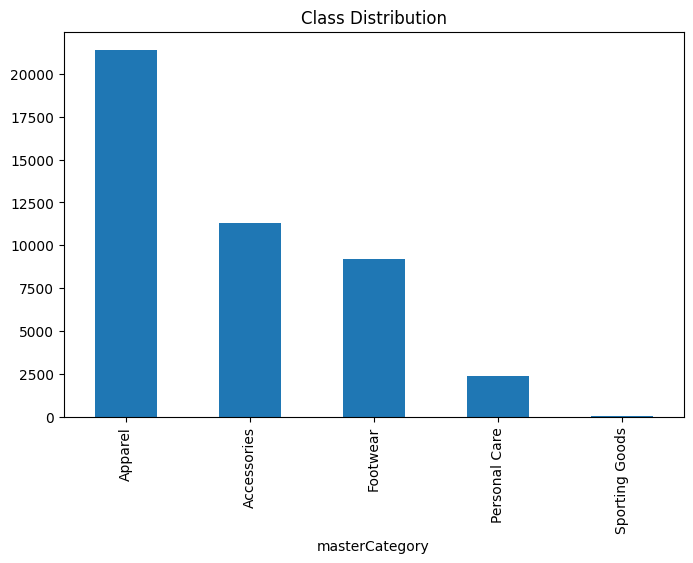

In [17]:
counts = df['masterCategory'].value_counts()
plt.figure(figsize=(8,5))
counts.plot(kind='bar')
plt.title("Class Distribution")
plt.show()


Text Preprocessing 

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Split data
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['masterCategory']
)

# Remove rows where productDisplayName is NaN
train_df = train_df.dropna(subset=['productDisplayName'])
test_df = test_df.dropna(subset=['productDisplayName'])

# TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
vectorizer.fit(train_df['productDisplayName'])

# Transform text to numerical features
X_train_text = vectorizer.transform(train_df['productDisplayName'])
X_test_text = vectorizer.transform(test_df['productDisplayName'])

print("TF-IDF shape:", X_train_text.shape)


TF-IDF shape: (35444, 5000)


Image Preprocessing 

In [19]:
import torch
from torchvision import models, transforms
from PIL import Image

# Preprocessing for images
image_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load pretrained ResNet50 and remove last layer
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # remove final FC layer
resnet.eval()


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [20]:
import torch
from tqdm import tqdm
import numpy as np

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)

def extract_features_batch(image_paths):
    batch_tensors = []
    for img_path in image_paths:
        try:
            img = Image.open(os.path.join(IMAGE_DIR, img_path)).convert('RGB')
            tensor = image_transform(img)
            batch_tensors.append(tensor)
        except Exception as e:
            print(f"Error: {img_path}, {e}")
    if not batch_tensors:
        return None
    batch = torch.stack(batch_tensors).to(device)
    with torch.no_grad():
        feats = resnet(batch).squeeze()
    return feats.cpu().numpy()

# Extract features for ALL train images in batches
batch_size = 64
all_train_feats = []
paths = train_df['image_path'].values

for i in tqdm(range(0, len(paths), batch_size)):
    batch_paths = paths[i:i+batch_size]
    batch_feats = extract_features_batch(batch_paths)
    if batch_feats is not None:
        all_train_feats.append(batch_feats)

X_train_image = np.vstack(all_train_feats)
np.save("X_train_image.npy", X_train_image)
print("Image features shape:", X_train_image.shape)

# Do the same for test images
all_test_feats = []
paths = test_df['image_path'].values

for i in tqdm(range(0, len(paths), batch_size)):
    batch_paths = paths[i:i+batch_size]
    batch_feats = extract_features_batch(batch_paths)
    if batch_feats is not None:
        all_test_feats.append(batch_feats)

X_test_image = np.vstack(all_test_feats)
np.save("X_test_image.npy", X_test_image)
print("Test image features shape:", X_test_image.shape)


100%|██████████| 554/554 [1:25:56<00:00,  9.31s/it]


Image features shape: (35444, 2048)


100%|██████████| 139/139 [1:45:29<00:00, 45.53s/it]    


Test image features shape: (8862, 2048)


In [21]:
import numpy as np

X_train_image = np.load("X_train_image.npy")
X_test_image = np.load("X_test_image.npy")


In [22]:
from scipy.sparse import hstack

# Convert to sparse and then combine (better for large data)
# First convert image features to sparse
from scipy.sparse import csr_matrix

X_train_combined = hstack([X_train_text, csr_matrix(X_train_image)])
X_test_combined = hstack([X_test_text, csr_matrix(X_test_image)])

print("Combined feature shape:", X_train_combined.shape)


Combined feature shape: (35444, 7048)


In [23]:
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
y_train = label_enc.fit_transform(train_df['masterCategory'])
y_test = label_enc.transform(test_df['masterCategory'])


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_combined, y_train)

y_pred = clf.predict(X_test_combined)
print(classification_report(y_test, y_pred, target_names=label_enc.classes_))


                precision    recall  f1-score   support

   Accessories       0.99      0.99      0.99      2255
       Apparel       1.00      1.00      1.00      4278
      Footwear       1.00      1.00      1.00      1844
 Personal Care       0.98      0.99      0.98       480
Sporting Goods       1.00      0.80      0.89         5

      accuracy                           0.99      8862
     macro avg       0.99      0.95      0.97      8862
  weighted avg       0.99      0.99      0.99      8862



In [25]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train_combined, y_train)
print(rf.score(X_test_combined, y_test))


0.9870232453170842


In [26]:
clf_text = LogisticRegression(max_iter=1000)
clf_text.fit(X_train_text, y_train)
print("Text-only model performance:")
print(clf_text.score(X_test_text, y_test))


Text-only model performance:
0.9974046490634169


In [27]:
import joblib

joblib.dump(clf, "multimodal_model.pkl")
joblib.dump(label_enc, "label_encoder.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']

In [29]:
from PIL import Image
import torch
import numpy as np
import os

def extract_image_features(img_path):
    img = Image.open(img_path).convert('RGB')
    img_tensor = image_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        features = resnet(img_tensor)
    return features.squeeze().cpu().numpy()


In [30]:
def predict_category(image_path, text):
    # Extract image features
    img_feat = extract_image_features(image_path).reshape(1, -1)
    # Extract text features
    txt_feat = vectorizer.transform([text])
    # Combine
    from scipy.sparse import hstack, csr_matrix
    combined = hstack([txt_feat, csr_matrix(img_feat)])
    # Predict
    pred = clf.predict(combined)
    return label_enc.inverse_transform(pred)[0]

# Example usage:
print(predict_category("images/15970.jpg", "Turtle Check Men Navy Blue Shirt"))


Apparel
